## 1. Import Packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import pickle
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn import set_config

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from imblearn.pipeline import Pipeline

## 2. Import data:

In [3]:
from sqlalchemy import create_engine

# Define connection parameters
server = r'DESKTOP-CBADVFM\SQLEXPRESS'  # Use raw string or double backslashes
database = 'DE_CAPSTONE_PROJECT'        # Database name without brackets

# Create connection string for Windows Authentication
connection_string = f'mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver=SQL+Server'

# Create engine
engine = create_engine(connection_string)

In [4]:
final_table = pd.read_sql('select * from [dbo].[final_table]',engine,parse_dates=['hire_date','birth_date','last_date'])
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date
278707,288003,Odoardo,Salinas,1963-10-21,F,s0002,Senior Staff,40000.0,1,d009,Customer Service,1988-03-03,3,B,False,NaT
166240,103965,Sverrir,Baba,1953-12-12,F,s0001,Staff,85514.0,1,d002,Finance,1986-05-20,6,A,False,NaT
286121,294743,Steve,Magalhaes,1958-07-18,M,s0001,Staff,40000.0,1,d009,Customer Service,1993-01-03,2,C,False,NaT
120236,58357,Djenana,Vecchi,1952-11-07,M,e0003,Senior Engineer,46870.0,1,d004,Production,1985-08-02,5,C,False,NaT
190294,207628,Annemarie,Slobodova,1960-02-01,F,e0003,Senior Engineer,45326.0,1,d005,development,1985-11-11,6,B,False,NaT


## 3. EDA:

In [9]:
final_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300024 entries, 0 to 300023
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   emp_no                   300024 non-null  object        
 1   first_name               300024 non-null  object        
 2   last_name                300024 non-null  object        
 3   birth_date               300024 non-null  datetime64[ns]
 4   sex                      300024 non-null  object        
 5   emp_title_id             300024 non-null  object        
 6   title                    300024 non-null  object        
 7   salary                   300024 non-null  float64       
 8   no_of_departments        300024 non-null  int64         
 9   dept_nos                 300024 non-null  object        
 10  dept_names               300024 non-null  object        
 11  hire_date                300024 non-null  datetime64[ns]
 12  no_of_projects  

In [11]:
max_last_date =pd.to_datetime(final_table['last_date']).max()
max_last_date

Timestamp('2013-03-10 00:00:00')

In [13]:
final_table['hire_date'] = pd.to_datetime(final_table['hire_date'])
final_table['last_date'] = pd.to_datetime(final_table['last_date'])

final_table['tenure'] = final_table['tenure'] = (
    (final_table['last_date'].fillna(max_last_date) - final_table['hire_date']).dt.days / 365
)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure
78340,46951,Sibyl,Bugrara,1959-01-09,M,e0003,Senior Engineer,74459.0,1,d005,development,1987-02-27,4,B,False,NaT,26.049315
191770,20897,Satoru,Senzako,1958-12-22,F,s0001,Staff,100302.0,1,d007,Sales,1987-10-18,9,C,False,NaT,25.410959
119473,57594,Ekawit,Pena,1956-02-17,F,e0002,Engineer,40000.0,1,d006,Quality Management,1986-07-01,9,B,False,NaT,26.709589
40305,434932,Yonghong,Klassen,1960-10-22,M,e0004,Technique Leader,46711.0,1,d004,Production,1986-12-12,2,S,False,NaT,26.260274
199696,216175,Rafael,Linares,1960-05-26,M,e0003,Senior Engineer,41845.0,2,"d004, d005","Production, development",1986-09-15,10,PIP,False,NaT,26.501370


In [15]:
final_table['birth_date'] = pd.to_datetime(final_table['birth_date'])
final_table['last_date'] = pd.to_datetime(final_table['last_date'])
final_table['age'] = ((final_table['last_date'].fillna(max_last_date) - final_table['birth_date']).dt.days / 365
)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure,age
116280,54401,Goo,Boudaillier,1962-06-20,F,e0003,Senior Engineer,40000.0,1,d005,development,1989-01-19,8,A,False,NaT,24.153425,50.756164
291609,299732,Mang,Sidhu,1952-07-19,F,s0001,Staff,40000.0,2,"d004, d009","Production, Customer Service",1987-04-22,3,PIP,False,NaT,25.901370,60.682192
27803,423567,Jiann,Reinhard,1953-05-13,M,s0002,Senior Staff,76608.0,1,d001,Marketing,1996-12-03,7,C,False,NaT,16.276712,59.865753
34394,429559,Guoxiang,Guting,1955-12-30,F,e0002,Engineer,40000.0,1,d006,Quality Management,1992-08-09,3,C,False,NaT,20.597260,57.232877
186656,204320,Danil,Neiman,1963-09-10,F,s0002,Senior Staff,55800.0,1,d002,Finance,1988-07-28,8,C,False,NaT,24.632877,49.531507


In [17]:
final_table['tenure'] = (final_table['tenure'] * 12).round().astype(int)

In [19]:
final_table.tenure.max()

338

In [21]:
final_table.tenure.min()

16

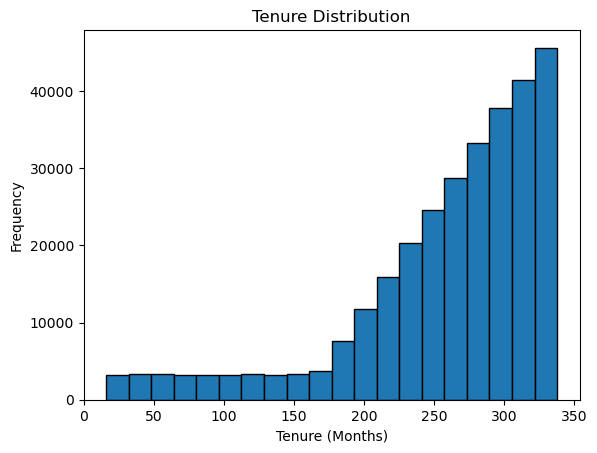

In [23]:
plt.hist(final_table['tenure'], bins=20, edgecolor='black')
plt.xlabel("Tenure (Months)")
plt.ylabel("Frequency")
plt.title("Tenure Distribution")
plt.show()

In [25]:
skewness = skew(final_table['tenure'])
print("Skewness:", skewness)

Skewness: -1.4736073636020948


In [27]:
final_table['age'] = final_table['age'].round().astype(int)
final_table.sample(5)

,emp_no,first_name,last_name,birth_date,sex,emp_title_id,title,salary,no_of_departments,dept_nos,dept_names,hire_date,no_of_projects,Last_performance_rating,left,last_date,tenure,age
69697,461652,Wilmer,Bain,1953-02-01,M,e0003,Senior Engineer,46264.0,1,d004,Production,1993-04-20,9,A,False,NaT,239,60
150792,88913,Sverrir,Munawer,1962-03-10,M,e0003,Senior Engineer,40000.0,1,d004,Production,1985-02-02,5,C,False,NaT,337,51
31672,427084,Mohammed,Berendt,1952-11-02,F,e0002,Engineer,40000.0,1,d005,development,1994-02-04,10,B,False,NaT,229,60
65603,457930,Denny,Cronin,1959-08-27,F,e0003,Senior Engineer,51524.0,1,d005,development,1988-10-14,5,B,False,NaT,293,54
75097,466561,Alenka,Mattern,1952-09-27,M,s0001,Staff,43958.0,1,d007,Sales,1991-06-18,7,B,False,NaT,261,60


In [29]:
final_table.age.max()

61

In [31]:
final_table.age.min()

22

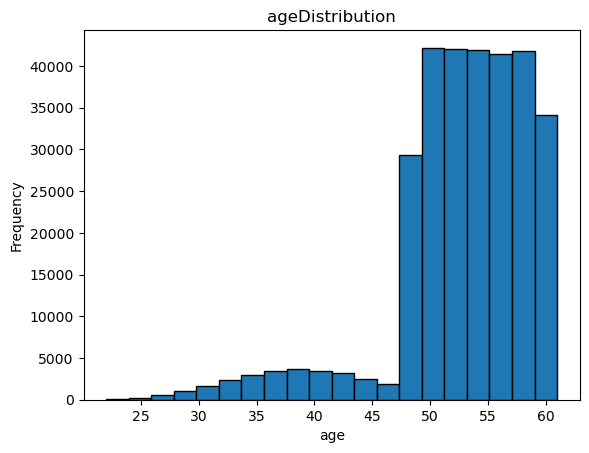

In [33]:
plt.hist(final_table['age'], bins=20, edgecolor='black')
plt.xlabel("age")
plt.ylabel("Frequency")
plt.title("ageDistribution")
plt.show()

In [35]:
skewness = skew(final_table['age'])
print("Skewness:", skewness)

Skewness: -1.5724469032098656


In [37]:
final_table.isnull().sum()

emp_no                          0
first_name                      0
last_name                       0
birth_date                      0
sex                             0
emp_title_id                    0
title                           0
salary                          0
no_of_departments               0
dept_nos                        0
dept_names                      0
hire_date                       0
no_of_projects                  0
Last_performance_rating         0
left                            0
last_date                  270157
tenure                          0
age                             0
dtype: int64

In [39]:
final_table.duplicated().sum()

0

In [40]:
final_table['left'] = final_table['left'].astype(int)

In [43]:
final_table_numeric = final_table.select_dtypes(include=['number'])  # Keep only numeric columns
correlation_with_left = final_table_numeric.corr()['left']
correlation_with_left

salary              -0.005035
no_of_departments    0.000376
no_of_projects       0.003164
left                 1.000000
tenure              -0.797822
age                 -0.753562
Name: left, dtype: float64

In [45]:
x = final_table.drop(columns=['left'])

y = final_table['left']

In [47]:
x.drop(columns=['emp_no','first_name','last_name','emp_title_id','dept_nos','birth_date','last_date','hire_date'],inplace=True)

In [49]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300024 entries, 0 to 300023
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sex                      300024 non-null  object 
 1   title                    300024 non-null  object 
 2   salary                   300024 non-null  float64
 3   no_of_departments        300024 non-null  int64  
 4   dept_names               300024 non-null  object 
 5   no_of_projects           300024 non-null  int64  
 6   Last_performance_rating  300024 non-null  object 
 7   tenure                   300024 non-null  int32  
 8   age                      300024 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(4)
memory usage: 18.3+ MB


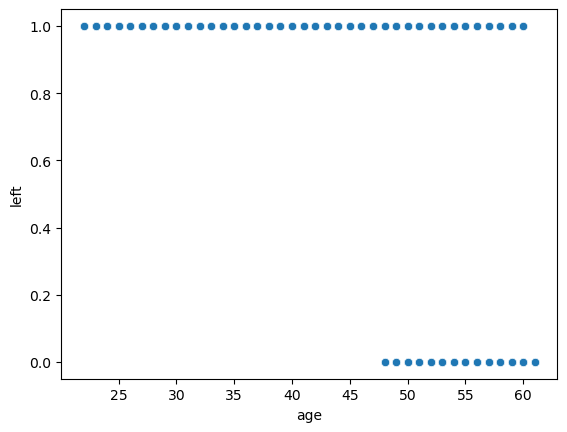

In [51]:
sns.scatterplot(x=final_table['age'],y=final_table['left'])
plt.show()

## 4. Building the Model:

## Logistic Regression

Important Features: ['cat__ordinal_tenure__tenure_category', 'cat__ordinal_age__age_group', 'cat__onehot_others__title_Senior Engineer', 'cat__onehot_others__title_Staff', 'cat__onehot_others__title_Senior Staff', 'cat__onehot_others__dept_names_Production, Customer Service', 'cat__onehot_others__dept_names_Quality Management', 'cat__onehot_others__title_Technique Leader', 'cat__onehot_others__dept_names_Production', 'cat__onehot_others__dept_names_development', 'cat__onehot_others__dept_names_Production, Quality Management', 'cat__onehot_others__dept_names_Marketing, Customer Service', 'cat__onehot_others__dept_names_Marketing, Sales', 'cat__onehot_others__dept_names_Production, development']


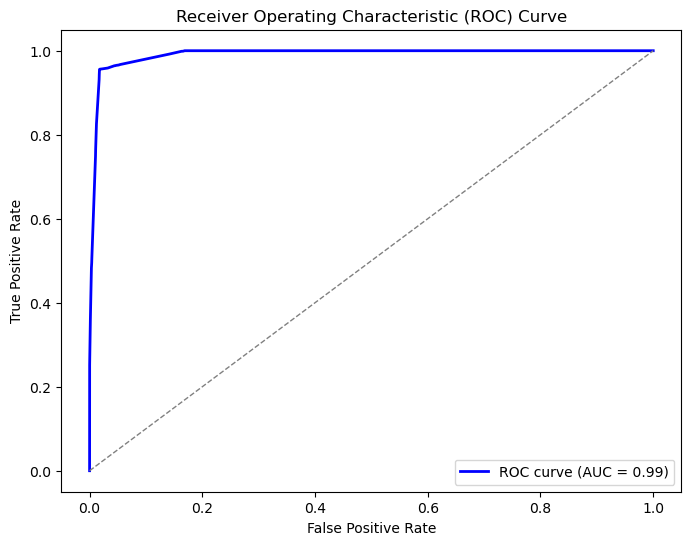

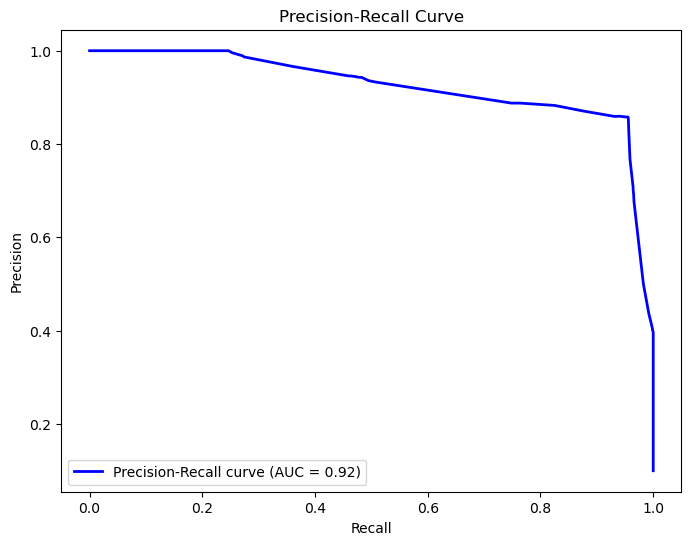

Accuracy: 0.9797516873593867
Confusion Matrix:
 [[53066   948]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9908632727914646
Precision-Recall AUC Score: 0.9239749480945876
Fitting 5 folds for each of 20 candidates, totalling 100 fits


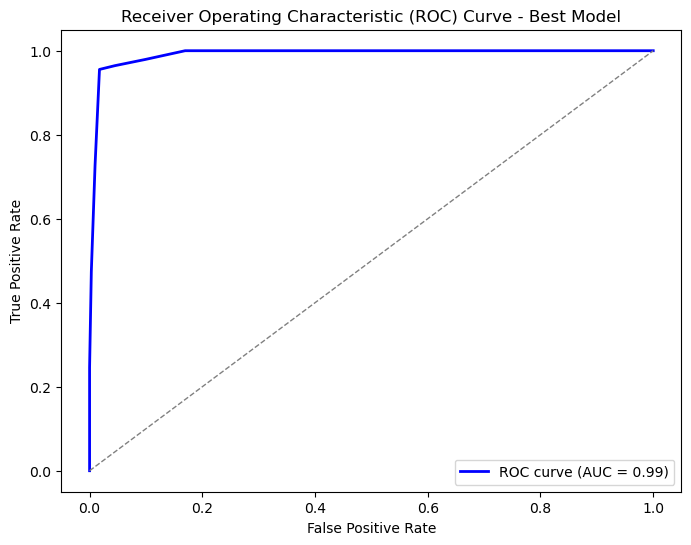

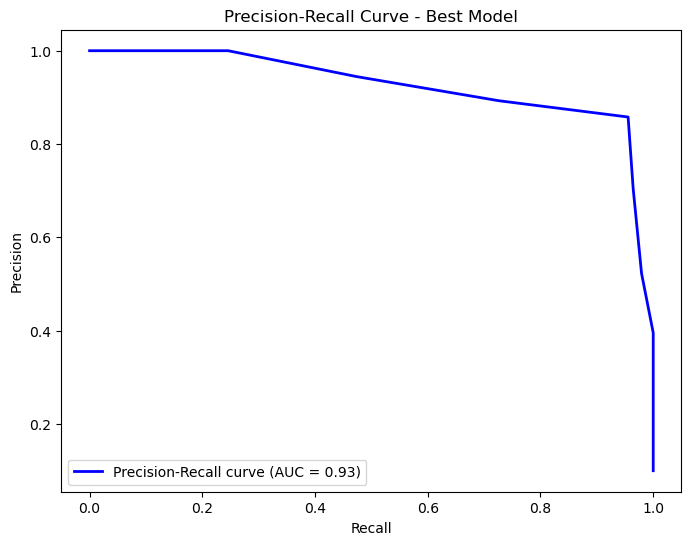

Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__class_weight': None, 'model__C': 0.01}
Accuracy: 0.9797516873593867
Confusion Matrix:
 [[53066   948]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9907844851910244
Precision-Recall AUC Score: 0.9256634087054032
Cross-validation accuracy scores: [0.97948088 0.97914757 0.97935589 0.9787726  0.97825136]
Mean accuracy: 0.9790016592423936


In [51]:
# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles_app = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Drop Unnecessary Columns
columns_to_remove = ['tenure', 'age']
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)

# Step 4: Define the Preprocessing Pipeline
# Identify categorical and numerical features
categorical_features = ['Last_performance_rating', 'sex', 'dept_names', 'title', 'tenure_category', 'age_group']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Preprocessing for categorical data
categorical_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), ['Last_performance_rating']),
        ('onehot_gender', OneHotEncoder(sparse_output=False, drop='first', categories=[['M', 'F']]), ['sex']),
        ('onehot_others', OneHotEncoder(sparse_output=False, drop='first'), ['dept_names', 'title']),
        ('ordinal_tenure', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), ['tenure_category']),
        ('ordinal_age', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), ['age_group'])
    ],
    remainder='passthrough'
)

# Preprocessing for numerical data (scaling)
numerical_transformer = StandardScaler()

# Combine preprocessing steps
transformer_app = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Step 5: Transform the Data
X_train_transformed = transformer_app.fit_transform(X_train)
X_test_transformed = transformer_app.transform(X_test)

# Step 6: Create DataFrames from Transformed Data
feature_names = transformer_app.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 7: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Train a Baseline Model for Feature Importance
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_transformed_df, y_train)

# Step 9: Calculate Feature Importance (Absolute Coefficients)
feature_importances = np.abs(baseline_model.coef_[0])  # Use absolute coefficients as importance
importance_df = pd.DataFrame({'Feature': X_train_transformed_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Filter Features Based on Importance
threshold = 0.2  
important_features_app = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
X_train_filtered = X_train_transformed_df[important_features_app]
X_test_filtered = X_test_transformed_df[important_features_app]
print('Important Features:', important_features_app)

# Step 11: Define the Final Model
model = LogisticRegression(random_state=42, max_iter=1000)

# Step 12: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

set_config(display='diagram')
pipeline

# Step 13: Fit the Pipeline on Filtered Data
pipeline.fit(X_train_filtered, y_train)

# Step 14: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_filtered)
y_pred_proba = pipeline.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 15: Hyperparameter Tuning
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'model__penalty': ['l1', 'l2'],  # Regularization type
    'model__solver': ['liblinear'],  # Solver for logistic regression
    'model__class_weight': [None, 'balanced']  # Class weights
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=2, n_jobs=-1, random_state=42, n_iter=20)
random_search.fit(X_train_filtered, y_train)

# Step 16: Evaluate the Best Model
best_model_app = random_search.best_estimator_
y_pred = best_model_app.predict(X_test_filtered)
y_pred_proba = best_model_app.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 17: Cross-Validation
cv_scores = cross_val_score(best_model_app, X_train_filtered, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

## Decision Tree

Important Features: ['tnf5__age_group', 'tnf4__tenure_category', 'remainder__salary', 'remainder__no_of_projects', 'tnf1__Last_performance_rating', 'tnf2__sex_F', 'tnf3__dept_names_Production', 'tnf3__dept_names_development']


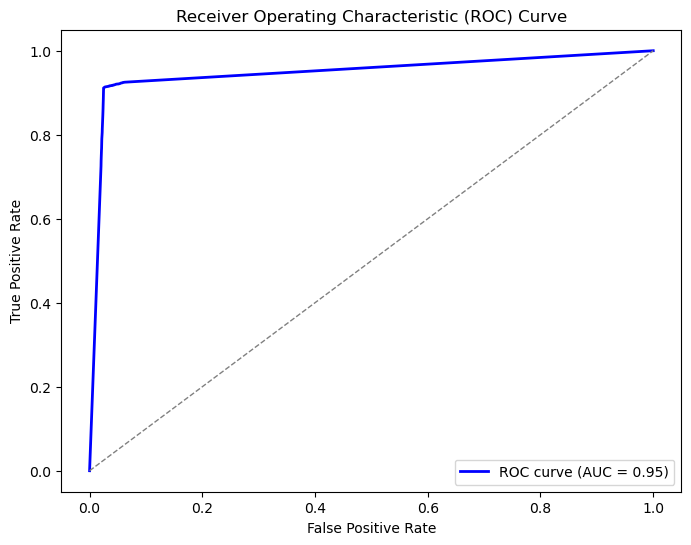

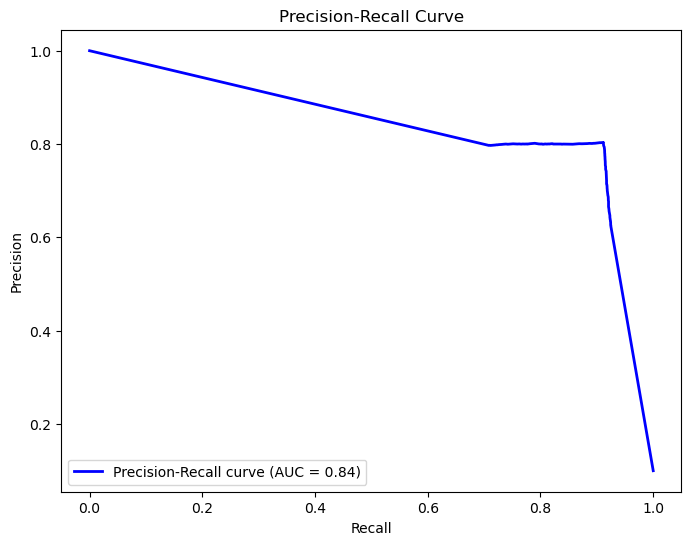

Accuracy: 0.9679526706107824
Confusion Matrix:
 [[52618  1396]
 [  527  5464]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     54014
           1       0.80      0.91      0.85      5991

    accuracy                           0.97     60005
   macro avg       0.89      0.94      0.92     60005
weighted avg       0.97      0.97      0.97     60005

ROC-AUC Score: 0.9479757274301498
Precision-Recall AUC Score: 0.8357152707861403
Fitting 5 folds for each of 10 candidates, totalling 50 fits


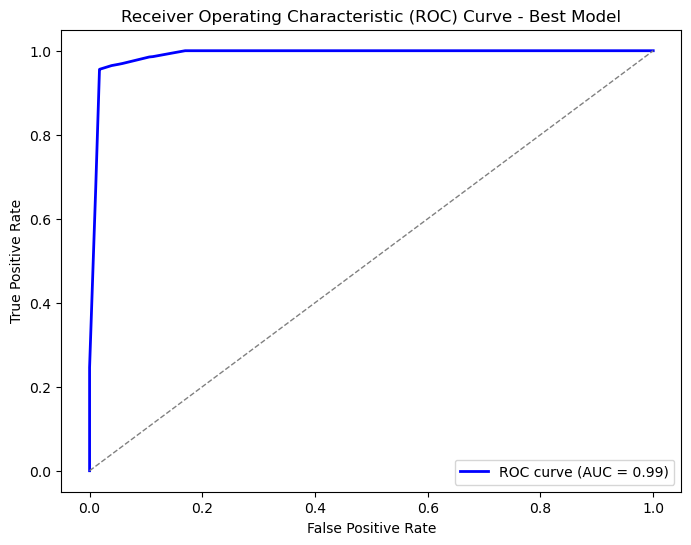

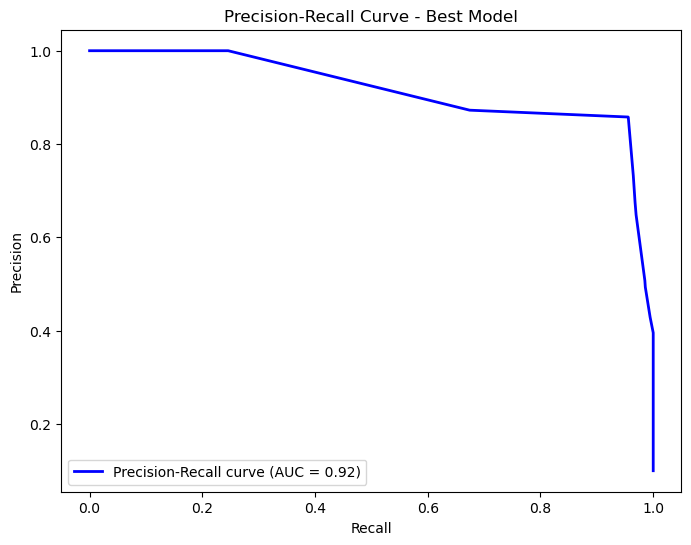

Best Parameters: {'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__criterion': 'entropy'}
Accuracy: 0.9796683609699192
Confusion Matrix:
 [[53059   955]
 [  265  5726]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9898142516844841
Precision-Recall AUC Score: 0.9166023432857331
Cross-validation accuracy scores: [0.97948088 0.97912674 0.97935589 0.9787726  0.97825136]
Mean accuracy: 0.9789974929229202


In [55]:

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Define the Preprocessing Pipeline
transformer = ColumnTransformer(
    transformers=[
        ('tnf1', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), [6]),  # Assuming column 6 is performance rating
        ('tnf2', OneHotEncoder(sparse_output=False, drop='first', categories=[['M', 'F']]), [0]),  # Assuming column 0 is gender
        ('tnf3', OneHotEncoder(sparse_output=False, drop='first'), [4, 1]),  # Assuming columns 4 and 1 are categorical
        ('tnf4', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), [9]),  # Assuming column 9 is tenure_category
        ('tnf5', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), [10])  # Assuming column 10 is age_group
    ],
    remainder='passthrough'
)

# Step 4: Transform the Data
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Step 5: Create DataFrames from Transformed Data
feature_names = transformer.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 6: Drop Unnecessary Columns
columns_to_remove = ['remainder__tenure', 'remainder__age']
X_train_transformed_df.drop(columns=columns_to_remove, inplace=True)
X_test_transformed_df.drop(columns=columns_to_remove, inplace=True)

# Step 7: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Train a Baseline Model for Feature Importance
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train_transformed_df, y_train)

# Step 9: Calculate Feature Importance
feature_importances = baseline_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_transformed_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Filter Features Based on Importance
threshold = 0.002 
important_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
X_train_filtered = X_train_transformed_df[important_features]
X_test_filtered = X_test_transformed_df[important_features]
print('Important Features:', important_features)

# Step 11: Define the Final Model
model = DecisionTreeClassifier(random_state=42)

# Step 12: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

set_config(display='diagram')
pipeline

# Step 13: Fit the Pipeline on Filtered Data
pipeline.fit(X_train_filtered, y_train)

# Step 14: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_filtered)
y_pred_proba = pipeline.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 15: Hyperparameter Tuning
param_grid = {
    'model__max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'model__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'model__min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
    'model__criterion': ['gini', 'entropy']  # Splitting criterion
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_filtered, y_train)

# Step 16: Evaluate the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_filtered)
y_pred_proba = best_model.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 17: Cross-Validation
cv_scores = cross_val_score(best_model, X_train_filtered, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

## Random Forest

Important Features: ['tnf5__age_group', 'tnf4__tenure_category', 'remainder__salary', 'remainder__no_of_projects', 'tnf1__Last_performance_rating']


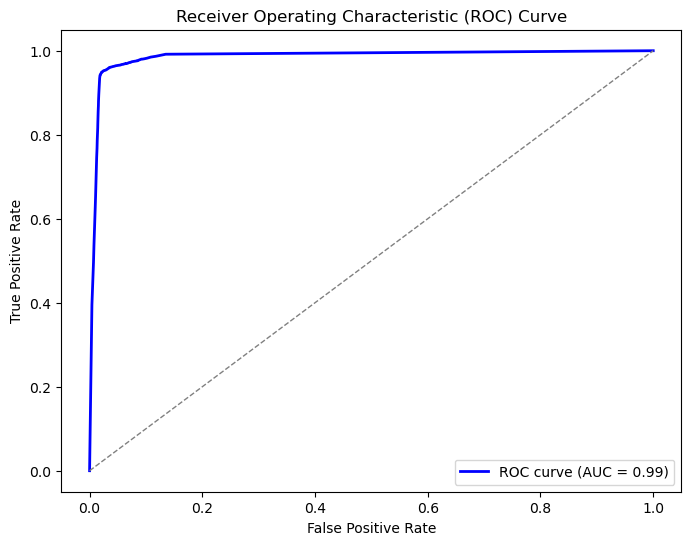

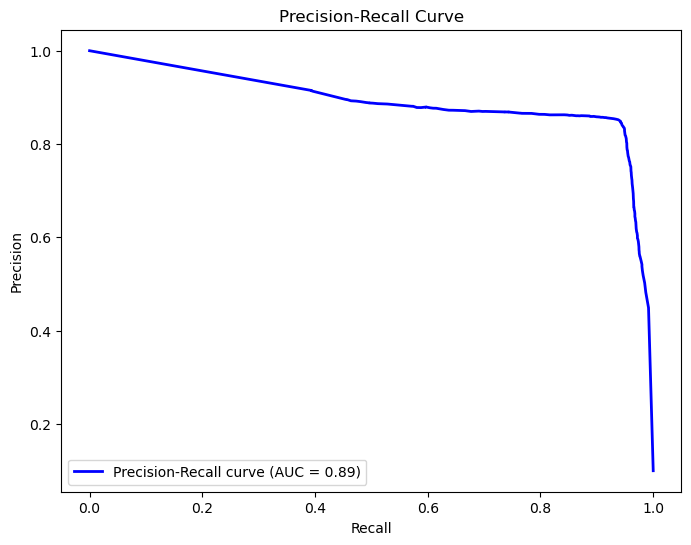

Accuracy: 0.9775185401216565
Confusion Matrix:
 [[53024   990]
 [  359  5632]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.85      0.94      0.89      5991

    accuracy                           0.98     60005
   macro avg       0.92      0.96      0.94     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9854086386859267
Precision-Recall AUC Score: 0.8920454963119566
Fitting 5 folds for each of 10 candidates, totalling 50 fits


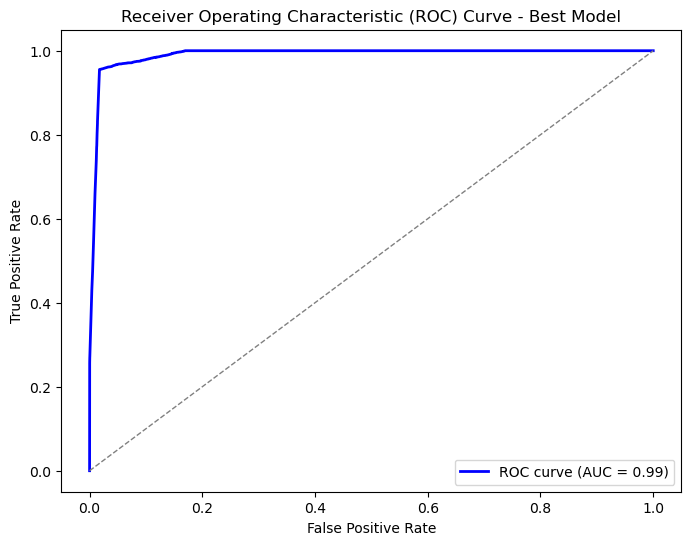

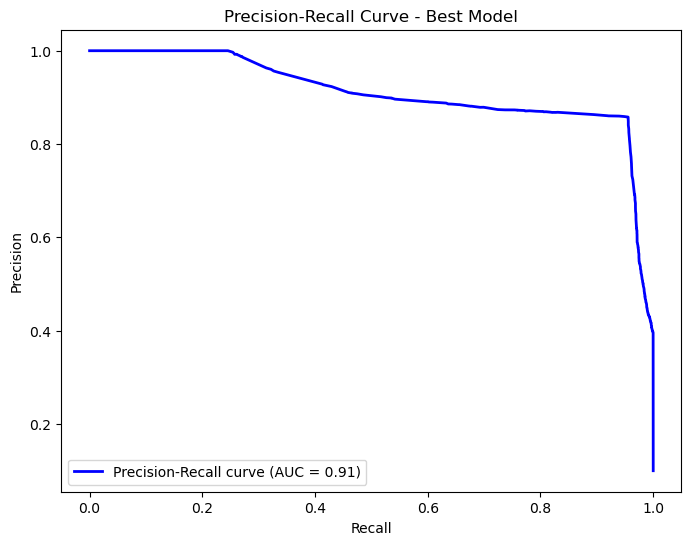

Best Parameters: {'model__oob_score': False, 'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_samples': 0.6, 'model__max_features': 0.7, 'model__max_depth': 5, 'model__bootstrap': True}
Accuracy: 0.9797516873593867
Confusion Matrix:
 [[53066   948]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9899106429234451
Precision-Recall AUC Score: 0.9108588057786625
Cross-validation accuracy scores: [0.97948088 0.97914757 0.97935589 0.9787726  0.97825136]
Mean accuracy: 0.9790016592423936


In [55]:

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Define the Preprocessing Pipeline
transformer = ColumnTransformer(
    transformers=[
        ('tnf1', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), [6]),  # Assuming column 6 is performance rating
        ('tnf2', OneHotEncoder(sparse_output=False, drop='first', categories=[['M', 'F']]), [0]),  # Assuming column 0 is gender
        ('tnf3', OneHotEncoder(sparse_output=False, drop='first'), [4, 1]),  # Assuming columns 4 and 1 are categorical
        ('tnf4', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), [9]),  # Assuming column 9 is tenure_category
        ('tnf5', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), [10])  # Assuming column 10 is age_group
    ],
    remainder='passthrough'
)

# Step 4: Transform the Data
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Step 5: Create DataFrames from Transformed Data
feature_names = transformer.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 6: Drop Unnecessary Columns
columns_to_remove = ['remainder__tenure', 'remainder__age']
X_train_transformed_df.drop(columns=columns_to_remove, inplace=True)
X_test_transformed_df.drop(columns=columns_to_remove, inplace=True)

# Step 7: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Train a Baseline Model for Feature Importance
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
baseline_model.fit(X_train_transformed_df, y_train)

# Step 9: Calculate Feature Importance
feature_importances = baseline_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_transformed_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 10: Filter Features Based on Importance
threshold = 0.012  
important_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()
X_train_filtered = X_train_transformed_df[important_features]
X_test_filtered = X_test_transformed_df[important_features]
print('Important Features:', important_features)

# Step 11: Define the Final Model
model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=0.60, random_state=42, max_depth=None, class_weight='balanced', oob_score=True)

# Step 12: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

set_config(display='diagram')
pipeline

# Step 13: Fit the Pipeline on Filtered Data
pipeline.fit(X_train_filtered, y_train)

# Step 14: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_filtered)
y_pred_proba = pipeline.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 15: Hyperparameter Tuning
param_grid = [
    {
        'model__n_estimators': [50, 100, 200],
        'model__max_features': [0.5, 0.7, 1.0],
        'model__max_depth': [5, 10, None],
        'model__bootstrap': [True],
        'model__max_samples': [0.6, 0.8, 1.0],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__oob_score': [True, False]
    },
    {
        'model__n_estimators': [50, 100, 200],
        'model__max_features': [0.5, 0.7, 1.0],
        'model__max_depth': [5, 10, None],
        'model__bootstrap': [False],
        'model__max_samples': [None],
        'model__min_samples_split': [2, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__oob_score': [False]
    }
]

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_filtered, y_train)

# Step 16: Evaluate the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_filtered)
y_pred_proba = best_model.predict_proba(X_test_filtered)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 17: Cross-Validation
cv_scores = cross_val_score(best_model, X_train_filtered, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

## Xgboost

C:\Users\Saheli\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


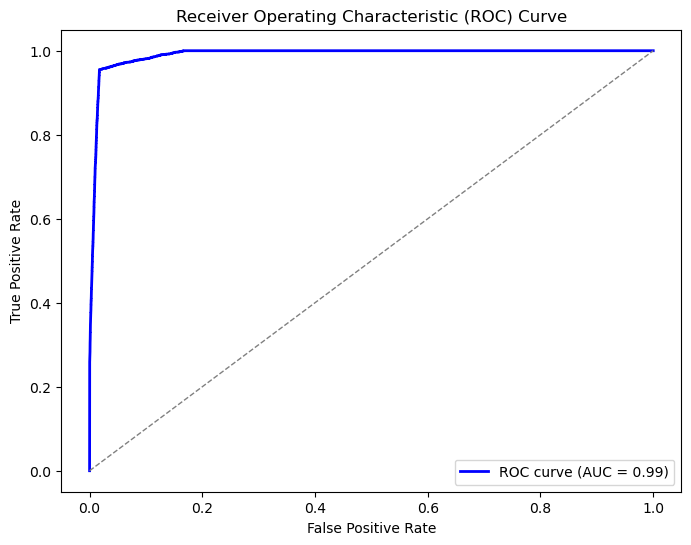

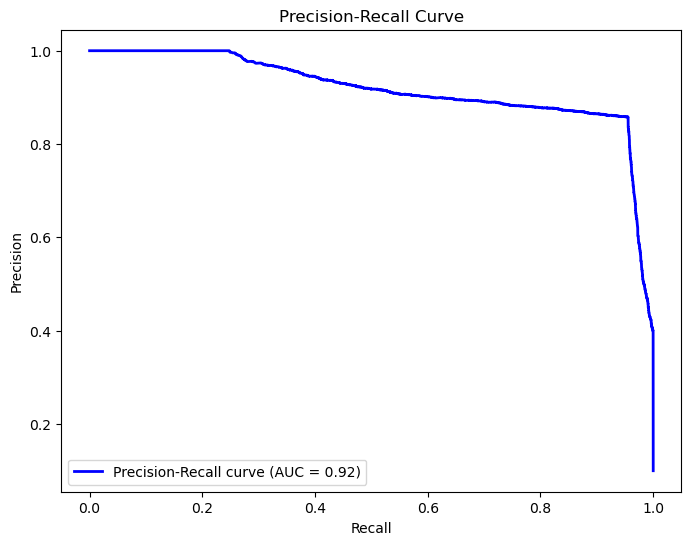

Accuracy: 0.9796516956920257
Confusion Matrix:
 [[53061   953]
 [  268  5723]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9906257186967798
Precision-Recall AUC Score: 0.9177821053726868
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Saheli\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


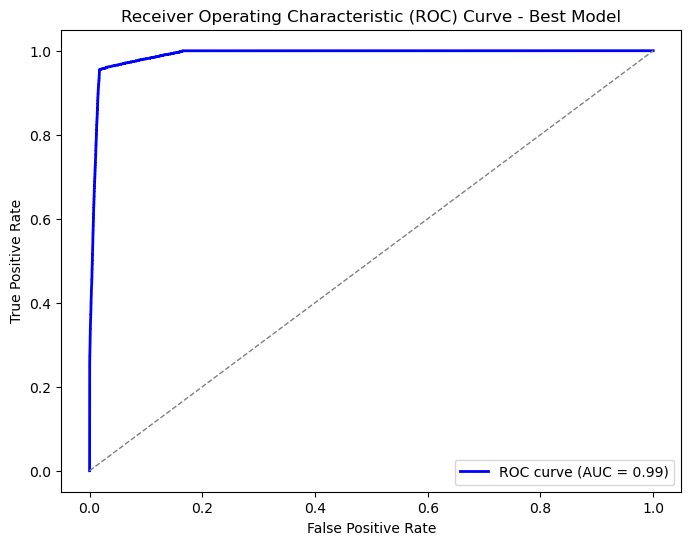

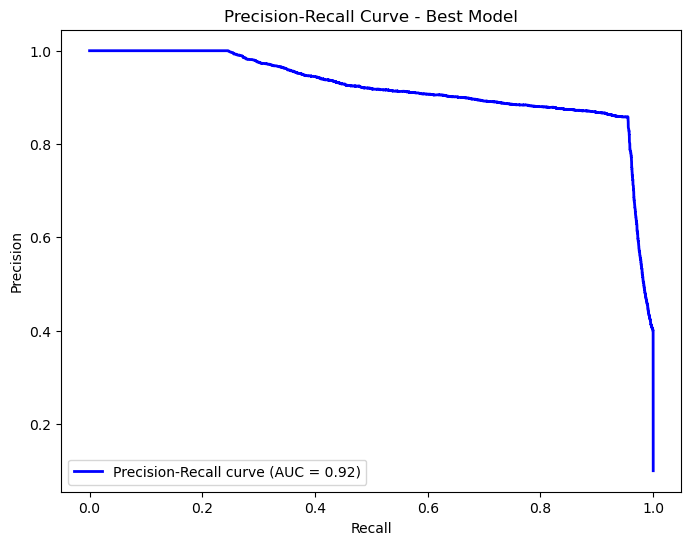

Best Parameters: {'model__subsample': 0.8, 'model__reg_lambda': 0.5, 'model__reg_alpha': 0, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 1.0}
Accuracy: 0.9796683609699192
Confusion Matrix:
 [[53061   953]
 [  267  5724]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     54014
           1       0.86      0.96      0.90      5991

    accuracy                           0.98     60005
   macro avg       0.93      0.97      0.95     60005
weighted avg       0.98      0.98      0.98     60005

ROC-AUC Score: 0.9906750314435008
Precision-Recall AUC Score: 0.9190714179089998


C:\Users\Saheli\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Saheli\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Saheli\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Saheli\anaconda3\Lib\site-packa

Cross-validation accuracy scores: [0.97948088 0.97914757 0.97935589 0.9787726  0.97827219]
Mean accuracy: 0.9790058256486598


In [61]:

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Define the Preprocessing Pipeline
transformer = ColumnTransformer(
    transformers=[
        ('tnf1', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), [6]),  # Assuming column 6 is performance rating
        ('tnf2', OrdinalEncoder(categories=[['M', 'F']]), [0]),  # Assuming column 0 is gender
        ('tnf3', OrdinalEncoder(), [4, 1]),  # Assuming columns 4 and 1 are categorical
        ('tnf4', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), [9]),  # Assuming column 9 is tenure_category
        ('tnf5', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), [10])  # Assuming column 10 is age_group
    ],
    remainder='passthrough'
)

# Step 4: Transform the Data
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

# Step 5: Create DataFrames from Transformed Data
feature_names = transformer.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 6: Drop Unnecessary Columns
columns_to_remove = ['remainder__tenure', 'remainder__age']
X_train_transformed_df.drop(columns=columns_to_remove, inplace=True)
X_test_transformed_df.drop(columns=columns_to_remove, inplace=True)

# Step 7: Resampling
smote = SMOTE(sampling_strategy=0.5, random_state=42)
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Define the Final Model
model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Step 9: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

set_config(display='diagram')
pipeline

# Step 10: Fit the Pipeline on Transformed Data
pipeline.fit(X_train_transformed_df, y_train)

# Step 11: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_transformed_df)
y_pred_proba = pipeline.predict_proba(X_test_transformed_df)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 12: Hyperparameter Tuning
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0, 0.1, 0.5],
    'model__reg_lambda': [0, 0.1, 0.5]
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, verbose=2, n_jobs=-1, random_state=42, n_iter=20)
random_search.fit(X_train_transformed_df, y_train)

# Step 13: Evaluate the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_transformed_df)
y_pred_proba = best_model.predict_proba(X_test_transformed_df)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 14: Cross-Validation
cv_scores = cross_val_score(best_model, X_train_transformed_df, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

## KNN 

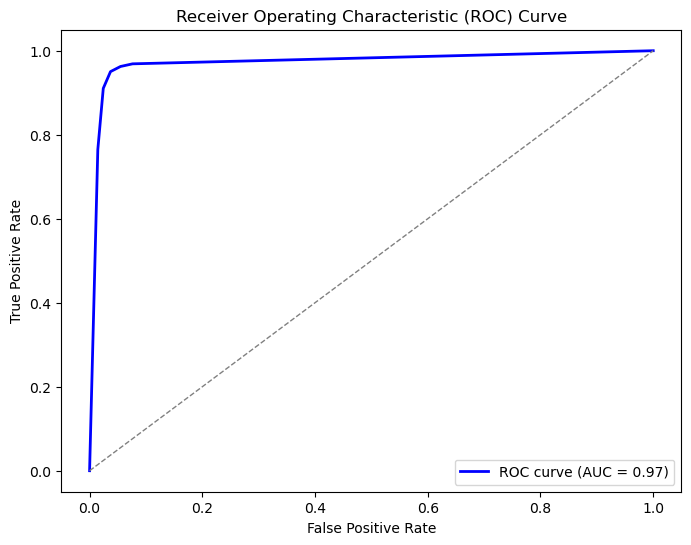

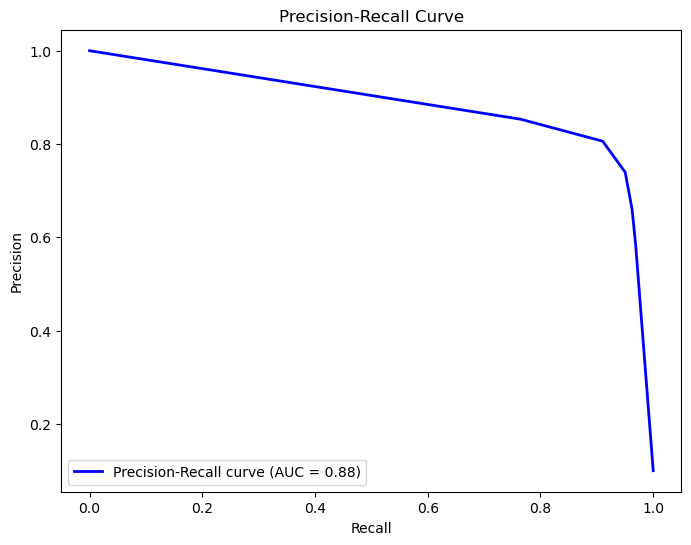

Accuracy: 0.9616198650112491
Confusion Matrix:
 [[52009  2005]
 [  298  5693]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     54014
           1       0.74      0.95      0.83      5991

    accuracy                           0.96     60005
   macro avg       0.87      0.96      0.91     60005
weighted avg       0.97      0.96      0.96     60005

ROC-AUC Score: 0.972591341870188
Precision-Recall AUC Score: 0.8834264363928893
Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\Saheli\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


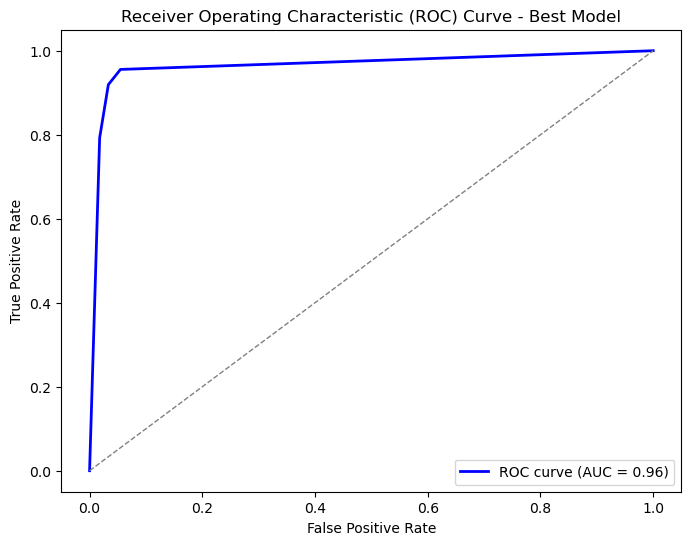

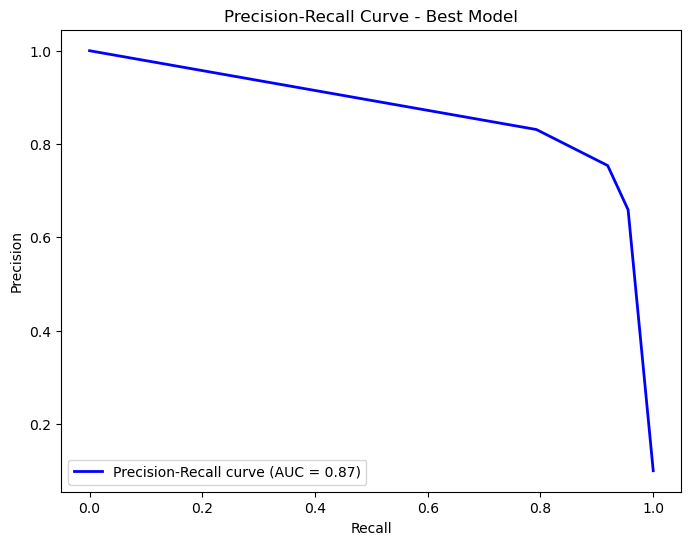

Best Parameters: {'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 3}
Accuracy: 0.9619698358470128
Confusion Matrix:
 [[52216  1798]
 [  484  5507]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     54014
           1       0.75      0.92      0.83      5991

    accuracy                           0.96     60005
   macro avg       0.87      0.94      0.90     60005
weighted avg       0.97      0.96      0.96     60005

ROC-AUC Score: 0.964583075412912
Precision-Recall AUC Score: 0.8685246594303675
Cross-validation accuracy scores: [0.96066994 0.95889926 0.95989918 0.95904508 0.960065  ]
Mean accuracy: 0.9597156906299306


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Step 1: Split the Data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Create tenure_category based on percentiles
percentiles_app = X_train['tenure'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist()
X_train['tenure_category'] = pd.cut(X_train['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)
X_test['tenure_category'] = pd.cut(X_test['tenure'], bins=percentiles_app, labels=['Low', 'Medium', 'High', 'Very High'], include_lowest=True)

# Create age_group based on bins
bins = [20, 35, 50, float('inf')]
labels = ['20-35', '35-50', '50+']
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)

# Step 3: Drop Unnecessary Columns
columns_to_remove = ['tenure', 'age']
X_train.drop(columns=columns_to_remove, inplace=True)
X_test.drop(columns=columns_to_remove, inplace=True)

# Step 4: Define the Preprocessing Pipeline
# Identify categorical and numerical features
categorical_features = ['Last_performance_rating', 'sex', 'dept_names', 'title', 'tenure_category', 'age_group']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Preprocessing for categorical data
categorical_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['PIP', 'C', 'B', 'S', 'A']]), ['Last_performance_rating']),
        ('onehot_gender', OneHotEncoder(sparse_output=False, drop='first', categories=[['M', 'F']]), ['sex']),
        ('onehot_others', OneHotEncoder(sparse_output=False, drop='first'), ['dept_names', 'title']),
        ('ordinal_tenure', OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']]), ['tenure_category']),
        ('ordinal_age', OrdinalEncoder(categories=[['20-35', '35-50', '50+']]), ['age_group'])
    ],
    remainder='passthrough'
)

# Preprocessing for numerical data (scaling)
numerical_transformer = StandardScaler()

# Combine preprocessing steps
transformer_app = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Step 5: Transform the Data
X_train_transformed = transformer_app.fit_transform(X_train)
X_test_transformed = transformer_app.transform(X_test)

# Step 6: Create DataFrames from Transformed Data
feature_names = transformer_app.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Step 7: Resampling (Reduced Sampling Strategy)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Reduced sampling strategy
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Step 8: Define the Final Model (KNN with Fewer Neighbors)
model = KNeighborsClassifier(n_neighbors=5)  # Use fewer neighbors

# Step 9: Define the Resampling and Modeling Pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('undersampler', undersampler),
    ('model', model)
])

# Step 10: Fit the Pipeline on Transformed Data
pipeline.fit(X_train_transformed_df, y_train)

# Step 11: Evaluate the Pipeline
y_pred = pipeline.predict(X_test_transformed_df)
y_pred_proba = pipeline.predict_proba(X_test_transformed_df)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 12: Hyperparameter Tuning (Reduced Search Space)
param_grid = {
    'model__n_neighbors': [3, 5, 7],  # Fewer neighbors
    'model__weights': ['uniform'],  # Only one option
    'model__p': [2]  # Only Euclidean distance
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=3, verbose=2, n_jobs=-1, random_state=42, n_iter=5)  # Reduced n_iter and cv
random_search.fit(X_train_transformed_df, y_train)

# Step 13: Evaluate the Best Model
best_model_app = random_search.best_estimator_
y_pred = best_model_app.predict(X_test_transformed_df)
y_pred_proba = best_model_app.predict_proba(X_test_transformed_df)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and AUC score for the best model
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Best Model')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and AUC for the best model
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve for the best model
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend(loc='lower left')
plt.show()

print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc)
print("Precision-Recall AUC Score:", pr_auc)

# Step 14: Cross-Validation (Reduced Folds)
cv_scores = cross_val_score(best_model_app, X_train_transformed_df, y_train, cv=5, scoring='accuracy')  # Reduced cv
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")